In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [41]:
# reflect an existing database into a new model
data= pd.read_sql('SELECT * FROM Station', engine )
data.head(2)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [42]:
data1= pd.read_sql('SELECT * FROM Measurement', engine )
sorted_data1 = data1.sort_values(by= ['id'], ascending=[True])
sorted_data1.tail(2)

,id,station,date,prcp,tobs
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [44]:
# We can view all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [45]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [47]:
# reflect the tables
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1be2d87f898>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [48]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1be2d07c320>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Print a date object and a datetime object 
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [51]:
# Query for the Date 1 year before `2017-08-23` using the datetime library
query_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23 00:00:00


In [52]:
# Perform a query to retrieve the data and precipitation scores
alldata = session.query(Measurement.date, Measurement.prcp, Measurement.station).filter (Measurement.date >query_date).all()

In [53]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(alldata).set_index('date')
prcp_df.head(2)


,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-25,0.08,USC00519397


In [54]:
# Sort the dataframe by date
prcp_df.sort_values(by= ['date'], ascending=[True], inplace=True)
prcp_df.head(2)

,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,NaN,USC00517948


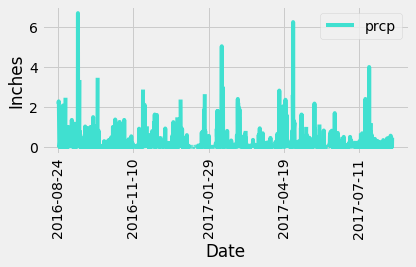

In [58]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90, color='turquoise')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [60]:
# Design a query to show how many stations are available in this dataset?
no_station = session.query(Station).distinct(Station.station).count()
no_station

9

In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
allstation = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
allstation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_max = session.query(func.max(Measurement.tobs).label("max_temp")).all()
temp_avg = session.query(func.avg(Measurement.tobs).label("avg_temp")).all()
print(f'the maximum temperature is : {temp_max}')
print(f'the average temperature is : {temp_avg}')

In [64]:
# Choose the station with the highest number of temperature observations.
max_station = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
max_station

('USC00519281', 2772)

In [65]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_row_station = session.query(Measurement.station, Measurement.tobs, Measurement.date ).\
        filter(Measurement.station == 'USC00519281').filter (Measurement.date >query_date).all()
max_sta_df = pd.DataFrame(max_row_station).set_index('date')
max_sta_df.head(2)

,station,tobs
date,,
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0


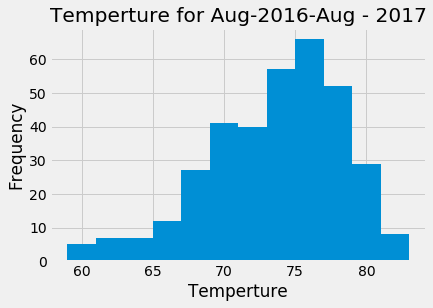

In [68]:
##plot the histogram
max_sta_df.hist(column='tobs', bins=12)

plt.ylabel('Frequency')
plt.xlabel('Temperture')
plt.title('Temperture for Aug-2016-Aug - 2017')
plt.savefig("Images/station-histogram.png")
plt.show()

## Bonus Challenge Assignment

In [16]:
#Bonus Temperature analysis -1

In [17]:
#Question DEC and June till t-test

In [18]:
#Bonus Temperature analysis -2

In [19]:
#Q1 Trip Average temperature

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'session' is not defined

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
#Question 2 Daily Rainfall

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [EA.family, EA.genus, EA.species, NA.family, NA.genus, NA.species]
same_sporder = session.query(*sel).filter(EA.sporder == NA.sporder).limit(10).all()

for record in same_sporder:
    (ea_fam, ea_gen, ea_spec, na_fam, na_gen, na_spec) = record
    print(
        f"The European animal '{ea_fam} {ea_gen} {ea_spec}'"
        f"belongs to the same sporder as the North American animal '{na_fam} {na_gen} {na_spec}'.")

NameError: name 'EA' is not defined

In [25]:
#Q3 Daily normals

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
